In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from torchsummary import summary
#vital params

 
model_name="DenseNet201"

dataset_name="caltech101"

#hyperparameters
batch_size=10
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Model: DenseNet201 with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketch': 55, 

In [2]:
#model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
#from .utils import load_state_dict_from_url


__all__ = ['DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161']



class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),

        self.drop_rate = drop_rate
        self.memory_efficient = memory_efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features

def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function



class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)  

    def forward(self, init_features):
        features = [init_features] 
        for name, layer in self.named_children():   
            new_features = layer(*features) 
            features.append(new_features)  
        return torch.cat(features, 1)   


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=num_classes, memory_efficient=False):

        super(DenseNet, self).__init__()


        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,  
                num_input_features=num_features,    
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,    
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)  
            num_features = num_features + num_layers * growth_rate 
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)  
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2   

        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(27040, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        
    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)
        xs = xs.view(-1, 10 * 52 * 52)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):

        features = self.features(x) 
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))   
        out = torch.flatten(out, 1)
        out = self.classifier(out) 
        return out

def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model


def densenet121(pretrained=False, progress=True, **kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)


def densenet161(pretrained=False, progress=True, **kwargs):
    r"""Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet161', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)


def densenet169(pretrained=False, progress=True, **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet169', 32, (6, 12, 48, 32), 64, pretrained, progress,
                     **kwargs)


def densenet201(pretrained=False, progress=True, **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet201', 32, (6, 12, 64, 48), 64, pretrained, progress,
                     **kwargs)


In [6]:
model = densenet201().to(device)
model = model.to(device)


#pretesting model for shape
x=torch.randn(batch_size,3,224,224)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print("model shape ready")
print(summary(model, input_size=(3, 224, 224)))
#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
print("model initialised")

torch.Size([10, 3, 224, 224])
torch.Size([10, 101])
model shape ready
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1

In [7]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [8]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+"/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs//DenseNet20120211221011748
grandstore_string
grandstore/caltech101_DenseNet20120211221011748.pkl


In [9]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [10]:
TOP_ACCURACY_TRACK = 5
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=200,
                    minepoch=120,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                  
                   )

Running epoch: 1


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 27.333
Training Loss: 8326418.6349 	Validation Loss: 6030.9438

Running epoch: 2


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 33.917
Training Loss: 6780543.3355 	Validation Loss: 5579.2678

Running epoch: 3


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 40.250
Training Loss: 6121334.9562 	Validation Loss: 3339.5989

Running epoch: 4


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 34.500
Training Loss: 5405421.1654 	Validation Loss: 7551.9691

Running epoch: 5


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 42.333
Training Loss: 4981215.1691 	Validation Loss: 3189.3670

Running epoch: 6


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 49.417
Training Loss: 4490563.3490 	Validation Loss: 2619.9644

Running epoch: 7


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 52.167
Training Loss: 3759353.2305 	Validation Loss: 2410.8344

Running epoch: 8


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 53.000
Training Loss: 3165851.4583 	Validation Loss: 2666.8476

Running epoch: 9


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.083
Training Loss: 2852178.7040 	Validation Loss: 2256.5384

Running epoch: 10


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.000
Training Loss: 2305969.7965 	Validation Loss: 1877.1226

Running epoch: 11


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 1962584.2604 	Validation Loss: 1767.9877

Running epoch: 12


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 1507275.9287 	Validation Loss: 1696.8081

Running epoch: 13


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 1185425.1289 	Validation Loss: 1854.4299

Running epoch: 14


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 962874.0219 	Validation Loss: 1583.7004

Running epoch: 15


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 781995.9640 	Validation Loss: 1557.6833

Running epoch: 16


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.083
Training Loss: 635178.9108 	Validation Loss: 1820.4282

Running epoch: 17


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 527594.1474 	Validation Loss: 1729.6086

Running epoch: 18


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 452216.6568 	Validation Loss: 1746.7895

Running epoch: 19


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 344123.4876 	Validation Loss: 1750.8286

Running epoch: 20


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 347967.8811 	Validation Loss: 1763.9505

Running epoch: 21


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 291104.0580 	Validation Loss: 1718.7766

Running epoch: 22


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 245998.2934 	Validation Loss: 1817.4711

Running epoch: 23


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 265932.0223 	Validation Loss: 1644.3860

Running epoch: 24


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 231205.3393 	Validation Loss: 1867.2714

Running epoch: 25


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 232667.1356 	Validation Loss: 1897.2982

Running epoch: 26


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 197572.4231 	Validation Loss: 1945.5964

Running epoch: 27


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 149074.8928 	Validation Loss: 1915.7064

Running epoch: 28


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 210779.9408 	Validation Loss: 2059.7001

Running epoch: 29


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 164964.7993 	Validation Loss: 1941.4212

Running epoch: 30


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 130642.6101 	Validation Loss: 1996.6419

Running epoch: 31


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.583
Training Loss: 141529.9700 	Validation Loss: 1886.8339

Running epoch: 32


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 139232.9730 	Validation Loss: 2621.3179

Running epoch: 33


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 217408.2076 	Validation Loss: 3389.1755

Running epoch: 34


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 116743.8407 	Validation Loss: 2520.0468

Running epoch: 35


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 122562.7776 	Validation Loss: 2129.1639

Running epoch: 36


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 168083.3614 	Validation Loss: 2025.7686

Running epoch: 37


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 141564.8913 	Validation Loss: 2095.5451

Running epoch: 38


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 94490.3789 	Validation Loss: 1841.7663

Running epoch: 39


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 102239.4136 	Validation Loss: 2410.8614

Running epoch: 40


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 132596.3697 	Validation Loss: 2257.3959

Running epoch: 41


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 137522.8744 	Validation Loss: 2175.8972

Running epoch: 42


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 179855.9420 	Validation Loss: 2067.0392

Running epoch: 43


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 80585.2188 	Validation Loss: 1914.7346

Running epoch: 44


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 48779.7381 	Validation Loss: 1878.7766

Running epoch: 45


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 64292.3735 	Validation Loss: 2364.0516

Running epoch: 46


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 131915.7724 	Validation Loss: 2156.5021

Running epoch: 47


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 123148.3973 	Validation Loss: 1805.5980

Running epoch: 48


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 88922.9293 	Validation Loss: 1934.9209

Running epoch: 49


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 61863.9856 	Validation Loss: 2085.5567

Running epoch: 50


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 74238.8138 	Validation Loss: 1855.1711

Running epoch: 51


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 96687.5816 	Validation Loss: 1954.2238

Running epoch: 52


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 119111.2458 	Validation Loss: 1823.9374

Running epoch: 53


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 51946.3826 	Validation Loss: 1777.1246

Running epoch: 54


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 41739.3577 	Validation Loss: 2003.7189

Running epoch: 55


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 118206.3878 	Validation Loss: 1846.0011

Running epoch: 56


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 71910.8559 	Validation Loss: 2009.0554

Running epoch: 57


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 145164.7901 	Validation Loss: 1812.4208

Running epoch: 58


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 32036.2843 	Validation Loss: 2285.3818

Running epoch: 59


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 61100.7412 	Validation Loss: 2112.3107

Running epoch: 60


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 77528.6816 	Validation Loss: 1929.5536

Running epoch: 61


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 46672.7184 	Validation Loss: 1892.1292

Running epoch: 62


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 85653.9687 	Validation Loss: 1947.7584

Running epoch: 63


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 65299.2790 	Validation Loss: 1979.3726

Running epoch: 64


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 87200.9271 	Validation Loss: 1942.1974

Running epoch: 65


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 55621.4659 	Validation Loss: 2063.1856

Running epoch: 66


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 72859.7063 	Validation Loss: 1837.6833

Running epoch: 67


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 39288.3740 	Validation Loss: 3341.2983

Running epoch: 68


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 70924.4284 	Validation Loss: 2107.5931

Running epoch: 69


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 59740.0881 	Validation Loss: 2004.6954

Running epoch: 70


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 63939.8783 	Validation Loss: 1979.5646

Running epoch: 71


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 57043.8672 	Validation Loss: 1826.1649

Running epoch: 72


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 35737.1524 	Validation Loss: 2001.5300

Running epoch: 73


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 43301.5165 	Validation Loss: 1999.4989

Running epoch: 74


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 63909.6945 	Validation Loss: 2119.0895

Running epoch: 75


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 48792.8619 	Validation Loss: 2068.4119

Running epoch: 76


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 50094.2109 	Validation Loss: 1989.1408

Running epoch: 77


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 36819.0419 	Validation Loss: 1960.9848

Running epoch: 78


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 51835.4840 	Validation Loss: 1888.1804

Running epoch: 79


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 29340.0537 	Validation Loss: 2074.7118

Running epoch: 80


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 55453.7509 	Validation Loss: 2000.5435

Running epoch: 81


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.000
Training Loss: 47254.4849 	Validation Loss: 1780.7791

Running epoch: 82


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 23915.8366 	Validation Loss: 2094.8111

Running epoch: 83


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.417
Training Loss: 47038.7069 	Validation Loss: 1788.1160

Running epoch: 84


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 47579.3305 	Validation Loss: 2187.2107

Running epoch: 85


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 44225.7463 	Validation Loss: 2014.3677

Running epoch: 86


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 32923.8151 	Validation Loss: 2003.0617

Running epoch: 87


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 51499.5539 	Validation Loss: 1962.2809

Running epoch: 88


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 58280.2773 	Validation Loss: 1832.7667

Running epoch: 89


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 22641.2993 	Validation Loss: 1758.8811

Running epoch: 90


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 14334.5743 	Validation Loss: 2150.0516

Running epoch: 91


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 34495.9267 	Validation Loss: 2147.5055

Running epoch: 92


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 51358.1491 	Validation Loss: 2287.0011

Running epoch: 93


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 43937.8651 	Validation Loss: 2234.9501

Running epoch: 94


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 23883.7443 	Validation Loss: 2078.2009

Running epoch: 95


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 53197.3789 	Validation Loss: 2638.6953

Running epoch: 96


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 47594.7289 	Validation Loss: 2216.5602

Running epoch: 97


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 29111.4195 	Validation Loss: 2493.9228

Running epoch: 98


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 46250.7132 	Validation Loss: 2271.5431

Running epoch: 99


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 33190.9643 	Validation Loss: 2148.0623

Running epoch: 100


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 22977.9029 	Validation Loss: 2171.6282

Running epoch: 101


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 87498.9363 	Validation Loss: 3884.9242

Running epoch: 102


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 40252.4946 	Validation Loss: 3721.8774

Running epoch: 103


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 19136.8830 	Validation Loss: 4110.5363

Running epoch: 104


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 13574.7015 	Validation Loss: 7400.8372

Running epoch: 105


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 30595.9385 	Validation Loss: 11471.3498

Running epoch: 106


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 98703.9263 	Validation Loss: 5110.3448

Running epoch: 107


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 33431.0935 	Validation Loss: 3491.1704

Running epoch: 108


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 36102.3220 	Validation Loss: 3169.9534

Running epoch: 109


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 15912.7576 	Validation Loss: 2029.3063

Running epoch: 110


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 24494.1194 	Validation Loss: 2090.8642

Running epoch: 111


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 31077.7354 	Validation Loss: 2105.3266

Running epoch: 112


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 28359.0852 	Validation Loss: 2160.2093

Running epoch: 113


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.000
Training Loss: 53271.0411 	Validation Loss: 2136.3257

Running epoch: 114


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 25529.4710 	Validation Loss: 2293.9551

Running epoch: 115


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.167
Training Loss: 27167.5122 	Validation Loss: 2110.3822

Running epoch: 116


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.167
Training Loss: 32104.4826 	Validation Loss: 1963.1610

Running epoch: 117


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 19508.2687 	Validation Loss: 2108.6551

Running epoch: 118


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 46556.3492 	Validation Loss: 2124.8387

Running epoch: 119


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 18511.6811 	Validation Loss: 2015.3198

Running epoch: 120


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 23573.2248 	Validation Loss: 2111.8544

Running epoch: 121


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 13667.2726 	Validation Loss: 2066.8486

Running epoch: 122


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.667
Training Loss: 42907.3996 	Validation Loss: 2111.0269

Running epoch: 123


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 24336.4704 	Validation Loss: 2005.2072

Running epoch: 124


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.583
Training Loss: 10704.2954 	Validation Loss: 2458.1470

Running epoch: 125


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 37961.4910 	Validation Loss: 8110.8858

Running epoch: 126


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 27584.8653 	Validation Loss: 6315.7616

Running epoch: 127


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 12238.7939 	Validation Loss: 2431.2937

Running epoch: 128


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 62789.9216 	Validation Loss: 2985.8939

Running epoch: 129


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 15752.3580 	Validation Loss: 5992.3636

Running epoch: 130


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 29914.5229 	Validation Loss: 2132.8652

Running epoch: 131


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 33823.1609 	Validation Loss: 2361.8325

Running epoch: 132


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 19984.3832 	Validation Loss: 2138.1843

Running epoch: 133


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 22841.5011 	Validation Loss: 2134.3530

Running epoch: 134


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 21405.0492 	Validation Loss: 2055.8513

Running epoch: 135


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 18813.5330 	Validation Loss: 2256.8131

Running epoch: 136


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 10827.2812 	Validation Loss: 2501.1370

Running epoch: 137


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 52636.3682 	Validation Loss: 2139.9937

Running epoch: 138


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 40993.6151 	Validation Loss: 2756.7489

Running epoch: 139


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 12993.0009 	Validation Loss: 11286.1752

Running epoch: 140


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 12883.9183 	Validation Loss: 2169.8144

Running epoch: 141


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 44509.2297 	Validation Loss: 8332.9850

Running epoch: 142


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 40514.4483 	Validation Loss: 8554.5679

Running epoch: 143


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.667
Training Loss: 14515.6075 	Validation Loss: 3576.6000

Running epoch: 144


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 12004.5857 	Validation Loss: 3001.9119

Running epoch: 145


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 21047.6852 	Validation Loss: 2240.7852

Running epoch: 146


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 29160.2769 	Validation Loss: 2355.0971

Running epoch: 147


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 40689.8387 	Validation Loss: 2170.6240

Running epoch: 148


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 17946.4100 	Validation Loss: 2047.6699

Running epoch: 149


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.167
Training Loss: 24913.7393 	Validation Loss: 5619.1535

Running epoch: 150


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 32620.7915 	Validation Loss: 2192.6178

Running epoch: 151


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 39208.5697 	Validation Loss: 2065.7889

Running epoch: 152


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 19792.4216 	Validation Loss: 2074.6210

Running epoch: 153


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.667
Training Loss: 13666.3593 	Validation Loss: 1942.8430

Running epoch: 154


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 8044.1907 	Validation Loss: 2164.5510

Running epoch: 155


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.583
Training Loss: 51256.2337 	Validation Loss: 2154.2163

Running epoch: 156


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 19501.3843 	Validation Loss: 2150.4923

Running epoch: 157


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 19307.4240 	Validation Loss: 1933.7627

Running epoch: 158


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 14116.0841 	Validation Loss: 2112.8111

Running epoch: 159


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 38041.9258 	Validation Loss: 2015.9630

Running epoch: 160


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.500
Training Loss: 20775.2660 	Validation Loss: 2016.8526

Running epoch: 161


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 13195.6324 	Validation Loss: 2084.5710

Running epoch: 162


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.500
Training Loss: 17093.2240 	Validation Loss: 1983.2146

Running epoch: 163


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 10271.2246 	Validation Loss: 2040.7848

Running epoch: 164


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 16332.6648 	Validation Loss: 2202.9322

Running epoch: 165


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.583
Training Loss: 38315.1265 	Validation Loss: 2027.4404

Running epoch: 166


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.250
Training Loss: 17208.5080 	Validation Loss: 1952.6470

Running epoch: 167


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 38693.9782 	Validation Loss: 2050.8291

Running epoch: 168


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.667
Training Loss: 14422.0684 	Validation Loss: 1979.1401

Running epoch: 169


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 19175.5439 	Validation Loss: 2115.0533

Running epoch: 170


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 11623.0869 	Validation Loss: 2123.5143

Running epoch: 171


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 19853.0531 	Validation Loss: 2093.1247

Running epoch: 172


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.583
Training Loss: 10523.6705 	Validation Loss: 2104.8228

Running epoch: 173


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 26649.4853 	Validation Loss: 2244.0521

Running epoch: 174


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 14325.6209 	Validation Loss: 2162.7665

Running epoch: 175


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 8226.9793 	Validation Loss: 2255.6829

Running epoch: 176


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 24438.5708 	Validation Loss: 2451.5023

Running epoch: 177


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 49829.0793 	Validation Loss: 2292.3865

Running epoch: 178


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 22480.8863 	Validation Loss: 2233.6358

Running epoch: 179


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 14622.8107 	Validation Loss: 2129.1485

Running epoch: 180


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.583
Training Loss: 14999.2001 	Validation Loss: 1936.1207

Running epoch: 181


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 3392.2288 	Validation Loss: 2037.7317

Running epoch: 182


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 35782.2327 	Validation Loss: 2014.7978

Running epoch: 183


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 78.083
Training Loss: 9479.7589 	Validation Loss: 1970.0411

Running epoch: 184


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.750
Training Loss: 8266.4055 	Validation Loss: 2151.0859

Running epoch: 185


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 13017.8293 	Validation Loss: 2238.7485

Running epoch: 186


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 32649.9616 	Validation Loss: 2476.9039

Running epoch: 187


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 22340.9196 	Validation Loss: 2273.8907

Running epoch: 188


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 5964.2043 	Validation Loss: 2367.9387

Running epoch: 189


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 10972.9627 	Validation Loss: 2374.3400

Running epoch: 190


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 77.250
Training Loss: 57491.1561 	Validation Loss: 2080.8807

Running epoch: 191


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 77.250
Training Loss: 14054.9934 	Validation Loss: 2082.9151

Running epoch: 192


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.667
Training Loss: 24709.6417 	Validation Loss: 2115.0352

Running epoch: 193


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 10096.6389 	Validation Loss: 2123.7534

Running epoch: 194


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.667
Training Loss: 6503.4849 	Validation Loss: 1969.0055

Running epoch: 195


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 19112.9969 	Validation Loss: 2130.6408

Running epoch: 196


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.667
Training Loss: 18652.0239 	Validation Loss: 2128.5990

Running epoch: 197


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 20033.7192 	Validation Loss: 2193.5414

Running epoch: 198


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 27438.6151 	Validation Loss: 2153.8366

Running epoch: 199


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 12377.2621 	Validation Loss: 2363.6684

Running epoch: 200


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.750
Training Loss: 17068.5791 	Validation Loss: 2092.9560



Total Run 200 epoch(s)
Accuracy MIN: 27.333333333333332 / MAX: 78.08333333333333

Top 5 performing epochs:
#1 epoch 183	||train_acc 78.08%	||test 80.83%
#2 epoch 200	||train_acc 77.75%	||test 79.58%
#3 epoch 184	||train_acc 77.75%	||test 78.42%
#4 epoch 194	||train_acc 77.67%	||test 79.75%
#5 epoch 168	||train_acc 77.67%	||test 78.17%

Last epoch:
epoch 200	||train_acc 77.75%	||test 79.58%

The model has parameters: 31995946


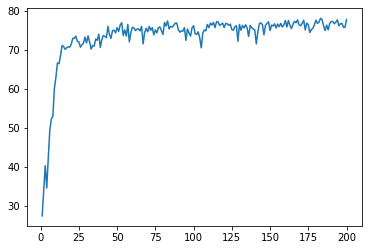

In [11]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [13]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)
# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/caltech101_DenseNet20120211221011748.pkl
